In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm.notebook import trange, tqdm #
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from core.utils.plot_utils import saveallforms
from core.gaussian_mixture_lib import GaussianMixture, GaussianMixture_torch

In [48]:

def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt...
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) ) # sqrt fixed Jun.19


def denoise_loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


def train_score_td(X_train_tsr, score_model_td=None,
                   sigma=25,
                   optimizer=None,
                   lr=0.005,
                   nepochs=750,
                   eps=1E-3,
                   batch_size=None,
                   clipnorm=None,
                   device="cpu",
                   callback_func=lambda score_model_td, epochs, loss: None,
                   callback_epochs=[]):
    ndim = X_train_tsr.shape[1]
    if score_model_td is None:
        score_model_td = ScoreModel_Time(sigma=sigma, ndim=ndim)
    score_model_td.to(device)
    X_train_tsr = X_train_tsr.to(device)
    marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
    if optimizer is None:
        optim = Adam(score_model_td.parameters(), lr=lr)
    else:
        print("Using provided optimizer, overriding lr")
        optim = optimizer
    pbar = trange(nepochs)
    score_model_td.train()
    loss_traj = []
    for ep in pbar:
        if batch_size is None:
            loss = denoise_loss_fn(score_model_td, X_train_tsr, marginal_prob_std_f, eps=eps)
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            loss = denoise_loss_fn(score_model_td, X_train_tsr[idx], marginal_prob_std_f, eps=eps)

        optim.zero_grad()
        loss.backward()
        if clipnorm is not None:
            torch.nn.utils.clip_grad_norm_(score_model_td.parameters(),
                                           max_norm=clipnorm)
        optim.step()
        pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        if ep == 0:
            print(f"step {ep} loss {loss.item():.3f}")
        if ep in callback_epochs:
            callback_func(score_model_td, ep, loss)
        loss_traj.append(loss.item())
    return score_model_td, loss_traj


def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float(), tvec).numpy()
    # simple Euler-Maryama integration of SGD
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev


def reverse_diffusion_time_dep_torch(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """More efficient version that run solely on device
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * math.log(sigma))
  xT = math.sqrt(lambdaT) * torch.randn(sampN, ndim, device=device)
  x_traj_rev = torch.zeros((sampN, ndim, nsteps), device="cpu")
  x_traj_rev[:, :, 0] = xT.cpu()
  dt = 1 / nsteps
  x_next = xT
  for i in range(1, nsteps):
      t = 1 - i * dt
      tvec = torch.ones((sampN,), device=device) * t
      eps_z = torch.randn_like(xT)
      with torch.no_grad():
        score_xt = score_model_td(x_next, tvec)
      # if exact:
      #     gmm_t = diffuse_gmm(score_model_td, t, sigma, device)
      #     score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
      # else:
      x_next = x_next + eps_z * (sigma ** t) * math.sqrt(dt) + score_xt * dt * sigma**(2*t)
      x_traj_rev[:, :, i] = x_next.cpu()

  return x_traj_rev


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh


In [4]:
def generate_spiral_samples_torch(n_points, a=1, b=0.2):
    """Generate points along a spiral using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - a, b (float): Parameters that define the spiral shape.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 4 * np.pi, n_points)  # angle theta
    r = a + b * theta  # radius
    x = r * torch.cos(theta)  # x = r * cos(theta)
    y = r * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch


def generate_ring_samples_torch(n_points, R=1, ):
    """
    Generate points along a Ring using PyTorch.
    Parameters:
    - n_points (int): Number of points to generate.
    - R: Radius of the ring.
    Returns:
    - torch.Tensor: Batch of vectors representing points on the spiral.
    """
    theta = torch.linspace(0, 2 * np.pi, n_points + 1, )  # angle theta
    theta = theta[:-1]
    x = R * torch.cos(theta)  # x = r * cos(theta)
    y = R * torch.sin(theta)  # y = r * sin(theta)
    spiral_batch = torch.stack((x, y), dim=1)
    return spiral_batch


In [5]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, t):
    t_proj = t.view(-1, 1) * self.W[None, :] * 2 * math.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class ScoreModel_Time_edm(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ndim=2, nlayers=5, nhidden=50, time_embed_dim=10,
               act_fun=nn.Tanh):
    super().__init__()
    self.embed = GaussianFourierProjection(time_embed_dim, scale=1)
    layers = []
    layers.extend([nn.Linear(time_embed_dim + ndim, nhidden), act_fun()])
    for _ in range(nlayers - 2):
        layers.extend([nn.Linear(nhidden, nhidden), act_fun()])
    layers.extend([nn.Linear(nhidden, ndim)])
    self.net = nn.Sequential(*layers)
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

  def forward(self, x, t):
    std_vec = self.marginal_prob_std_f(t)[:, None,]
    ln_std_vec = torch.log(std_vec) / 4
    t_embed = self.embed(ln_std_vec)
    pred = self.net(torch.cat((x / (1 + std_vec ** 2).sqrt(),
                               t_embed), dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / std_vec - x / (1 + std_vec ** 2)
    return pred


In [6]:
def gaussian_mixture_score_batch_sigma_torch(x, mus, Us, Lambdas, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch,N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N dim]
    :param Lambdas: [N batch, N comp, N dim]
    :param weights: [N comp,] or None
    :return:
    """
    if Lambdas.ndim == 2:
        Lambdas = Lambdas[None, :, :]
    ndim = x.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas), dim=-1)  # [N batch, N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists = torch.sum(rot_residuals ** 2 / Lambdas, dim=-1)  # [N batch, N comp]
    logprobs = -0.5 * (logdetSigmas + MHdists)  # [N batch, N comp]
    if weights is not None:
        logprobs += torch.log(weights)  # - 0.5 * ndim * torch.log(2 * torch.pi)  # [N batch, N comp]
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = torch.einsum("BCD,CED->BCE", - (rot_residuals / Lambdas),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs)  # [N batch, N dim]
    return score_vecs


def gaussian_mixture_lowrank_score_batch_sigma_torch(x,
                 mus, Us, Lambdas, sigma, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch,N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N rank]
    :param Lambdas: [N comp, N rank]
    :param sigma: [N batch,] or []
    :param weights: [N comp,] or None
    :return:
    """
    if Lambdas.ndim == 2:
        Lambdas = Lambdas[None, :, :]
    ndim = x.shape[-1]
    nrank = Us.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas + sigma[:, None, None] ** 2), dim=-1)  # [N batch, N comp,]
    logdetSigmas += (ndim - nrank) * 2 * torch.log(sigma)[:, None]  # [N batch, N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    residual_sqnorm = torch.sum(residuals ** 2, dim=-1)  # [N batch, N comp]
    Lambda_tilde = Lambdas / (Lambdas + sigma[:, None, None] ** 2)  # [N batch, N comp, N rank]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists_lowrk = torch.sum(rot_residuals ** 2 * Lambda_tilde, dim=-1)  # [N batch, N comp]
    logprobs = -0.5 * (logdetSigmas +
                       (residual_sqnorm - MHdists_lowrk) / sigma[:, None] ** 2)  # [N batch, N comp]
    if weights is not None:
        logprobs += torch.log(weights)
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = - residuals + torch.einsum("BCD,CED->BCE",
                                    (rot_residuals * Lambda_tilde),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs) / (sigma[:, None] ** 2)  # [N batch, N dim]
    return score_vecs


class GMM_ansatz_net(nn.Module):

    def __init__(self, ndim, n_components, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        self.n_components = n_components
        # normalize the weights
        mus = torch.randn(n_components, ndim)
        Us = torch.randn(n_components, ndim, ndim)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_components, ndim))
        self.logweights = nn.Parameter(torch.log(torch.ones(n_components) / n_components))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        return gaussian_mixture_score_batch_sigma_torch(x, self.mus, self.Us,
               self.logLambdas.exp()[None, :, :] + sigma[:, None, None] ** 2, self.logweights.exp())


class GMM_ansatz_net_lowrank(nn.Module):
    def __init__(self, ndim, n_components, n_rank, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        self.n_components = n_components
        # normalize the weights
        mus = torch.randn(n_components, ndim)
        Us = torch.randn(n_components, ndim, n_rank)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_components, n_rank))
        self.logweights = nn.Parameter(torch.log(torch.ones(n_components) / n_components))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        return gaussian_mixture_lowrank_score_batch_sigma_torch(x, self.mus, self.Us,
               self.logLambdas.exp(), sigma[:], self.logweights.exp())


class Gauss_ansatz_net(nn.Module):
    def __init__(self, ndim, n_rank=None, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        # normalize the weights
        mus = torch.randn(ndim)
        if n_rank is None:
            n_rank = ndim
        Us = torch.randn(ndim, n_rank)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_rank))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        # ndim = x.shape[-1]
        # nrank = Us.shape[-1]
        residuals = (x[:, :] - self.mus[None, :])  # [N batch, N dim]
        # residual_sqnorm = torch.sum(residuals ** 2, dim=-1)  # [N batch, ]
        Lambdas = self.logLambdas.exp()[None, :]
        Lambda_tilde = Lambdas / (Lambdas + sigma[:, None] ** 2)  # [N batch, N rank]
        rot_residuals = torch.einsum("BD,DE->BE", residuals, self.Us)  # [N batch, N comp, N dim]
        # MHdists_lowrk = torch.sum(rot_residuals ** 2 * Lambda_tilde, dim=-1)  # [N batch, N comp]
        compo_score_vecs = - residuals + torch.einsum("BE,DE->BD",
                              (rot_residuals * Lambda_tilde), self.Us)  # [N batch, N comp, N dim]
        score_vecs = compo_score_vecs / (sigma[:, None] ** 2)  # [N batch, N dim]
        return score_vecs


In [7]:
def test_lowrank_score_correct(n_components = 5, npnts = 40):
    # test low rank version
    ndim = 2
    n_rank = 1
    xs = torch.randn(npnts, ndim)
    mus = torch.randn(n_components, ndim)
    Us = torch.randn(n_components, ndim, n_rank)
    mus = mus / torch.norm(mus, dim=-1, keepdim=True)
    Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
    Us_ortho = Us[:, [-1, -2], :] * torch.tensor([1, -1])[None, :, None]
    # test ortho
    assert torch.allclose(torch.einsum("CDr,CDr->Cr", Us, Us_ortho), torch.zeros(n_components, n_rank))
    Lambdas_lowrank = torch.randn(n_components, n_rank).exp()
    # sigma = torch.tensor([1.0])
    sigma = torch.rand(npnts)
    score_lowrank = gaussian_mixture_lowrank_score_batch_sigma_torch(xs, mus, Us, Lambdas_lowrank, sigma)
    # built full rank basis
    Us_full = torch.cat((Us, Us_ortho), dim=-1)
    # build full rank noise covariance
    Lambdas_full = torch.cat((Lambdas_lowrank[None, :, :] + sigma[:, None, None] ** 2,
                              (sigma[:, None, None] ** 2).repeat(1, n_components, ndim - n_rank)), dim=-1)
    score_fullrank = gaussian_mixture_score_batch_sigma_torch(xs, mus, Us_full, Lambdas_full,)
    assert torch.allclose(score_lowrank, score_fullrank, atol=1e-4, rtol=1e-4)

test_lowrank_score_correct()

In [8]:
def test_lowrank_gauss_score_correct(n_components = 1, npnts = 40, ndim = 3,
    n_rank = 2):
    # test low rank version
    xs = torch.randn(npnts, ndim)
    mus = torch.randn(n_components, ndim)
    Us = torch.randn(n_components, ndim, n_rank)
    ts = torch.rand(npnts)
    sigmas = marginal_prob_std(ts, 5.0)
    mus = mus / torch.norm(mus, dim=-1, keepdim=True)
    Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
    # test ortho
    Lambdas_lowrank = torch.randn(n_components, n_rank).exp()
    score_lowrank = gaussian_mixture_lowrank_score_batch_sigma_torch(xs, mus, Us, Lambdas_lowrank, sigmas)

    net = Gauss_ansatz_net(ndim, n_rank, sigma=5.0)
    net.mus.data = mus[0]
    net.Us.data = Us[0]
    net.logLambdas.data = torch.log(Lambdas_lowrank)[0]
    # built full rank basis
    score_gauss = net(xs, ts)

    assert torch.allclose(score_lowrank, score_gauss, atol=1e-4, rtol=1e-4)

test_lowrank_gauss_score_correct()

In [9]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

dataset = MNIST(root="~/Datasets", train=True, download=False, transform=transforms.ToTensor())
Xtsr = dataset.data.float() / 255
Xtrain = Xtsr.reshape(Xtsr.shape[0], -1)
ytrain = dataset.targets

In [10]:
Xtrain_norm = (Xtrain - Xtrain.mean()) / Xtrain.std()
Xmean = Xtrain_norm.mean(dim=0)
covmat = torch.cov((Xtrain_norm - Xmean).T)
eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64))
eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
assert torch.allclose(eigvec.T @ eigvec, torch.eye(eigvec.shape[0]).to(torch.float64))
assert torch.allclose(eigvec @ torch.diag(eigval) @ eigvec.T, covmat.to(torch.float64))

Visualize the PC of MNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


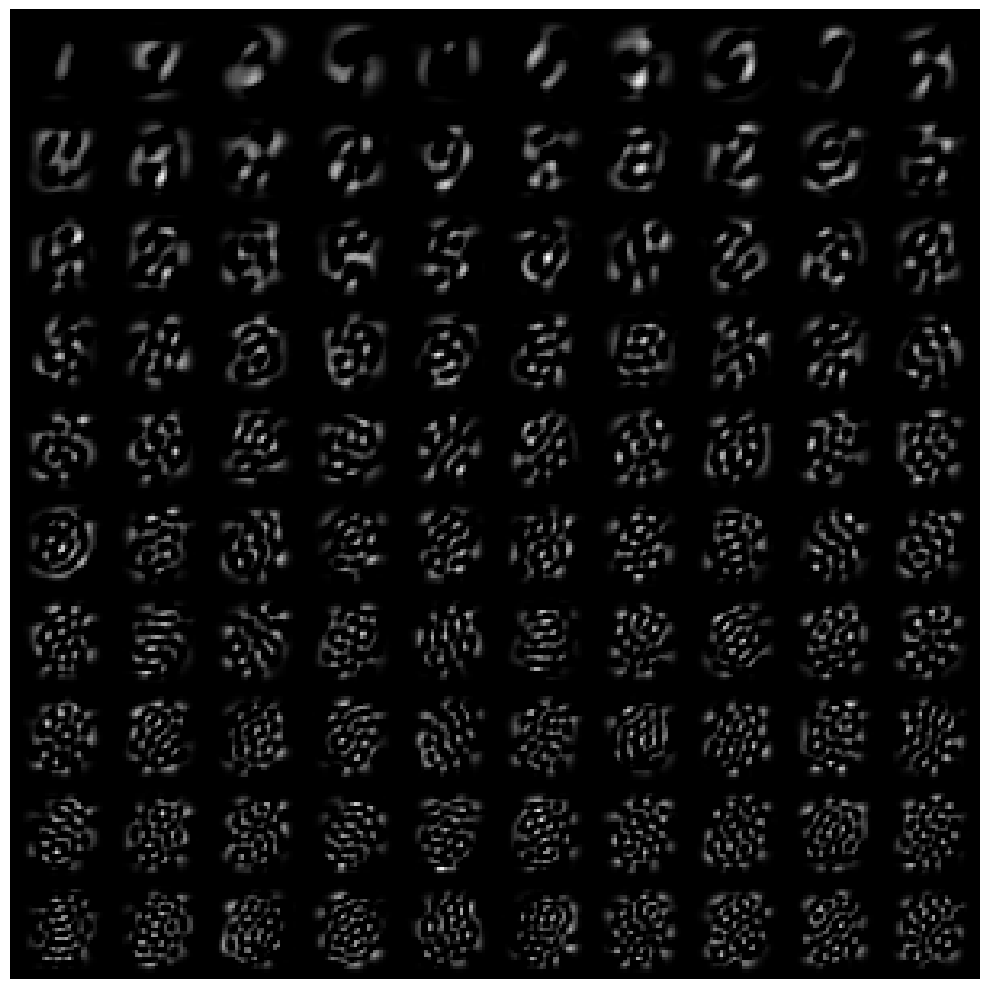

In [11]:
mtg = make_grid(eigvec.reshape(1, 28, 28, -1).permute(3,0,1,2)[:100], nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0) / mtg.max())
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
logLamda_init = torch.log(eigval + 1E-5).float()
U_init = eigvec.float()

## Single Gaussian Ansatz

In [12]:
ndim = Xtrain.shape[1]
sigma_max = 10
epochs = 2000
batch_size = 2048
torch.manual_seed(42)
score_model_gauss = Gauss_ansatz_net(ndim=ndim, sigma=sigma_max)
# Data PC initialization
score_model_gauss.logLambdas.data = logLamda_init[:]
score_model_gauss.Us.data = U_init[:, :]
# perturb = torch.randn(gmm_components, ndim)
# perturb = perturb / torch.norm(perturb, dim=-1, keepdim=True)
score_model_gauss.mus.data = Xmean[:]  # + perturb * 1

In [16]:
epochs = 10000
score_model_gauss, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gauss,
        sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="cuda") # clipnorm=1, 
# loss around 400 over 800 epochs, still very bad.
# parameter is over too much 30 Million for 50 components
# Training takes 20 mins for 2000 epochs

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 124.434


### GMM Ansatz

### 10 full rank GMM

In [14]:
ndim = Xtrain.shape[1]
gmm_components = 10
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
score_model_gmm.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
perturb = torch.randn(gmm_components, ndim)
perturb = perturb / torch.norm(perturb, dim=-1, keepdim=True)
score_model_gmm.mus.data = Xmean[None, :].repeat(gmm_components, 1) + perturb * 10

In [15]:
epochs = 10000
score_model_gmm, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm,
        sigma=sigma_max, lr=0.0005, nepochs=epochs, batch_size=batch_size, device="cuda") # clipnorm=1,
# 10 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 283.743
# step 1999 loss 108.833: 100%|██████████| 2000/2000 [07:53<00:00,  4.23it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 304.570


In [17]:
score_model_gmm, loss_traj = score_model_gmm

number of parameters 6162250


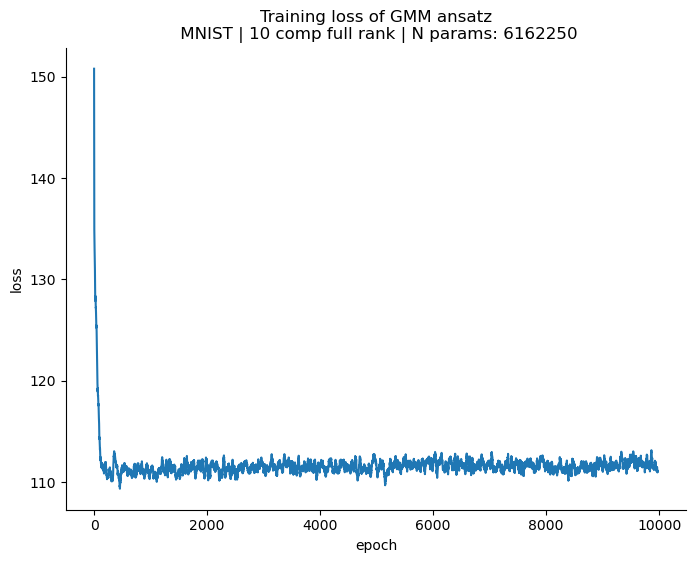

In [26]:
num_params = sum(p.numel() for p in score_model_gmm.parameters() if p.requires_grad)
print("number of parameters", num_params)
# 6 million parameters
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid)/ker_wid, mode='valid')
plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of GMM ansatz\n MNIST | {gmm_components} comp full rank | N params: {num_params}")
plt.show()

In [18]:
samples = reverse_diffusion_time_dep_torch(score_model_gmm, 
        sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, 
        exact=False, device="cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


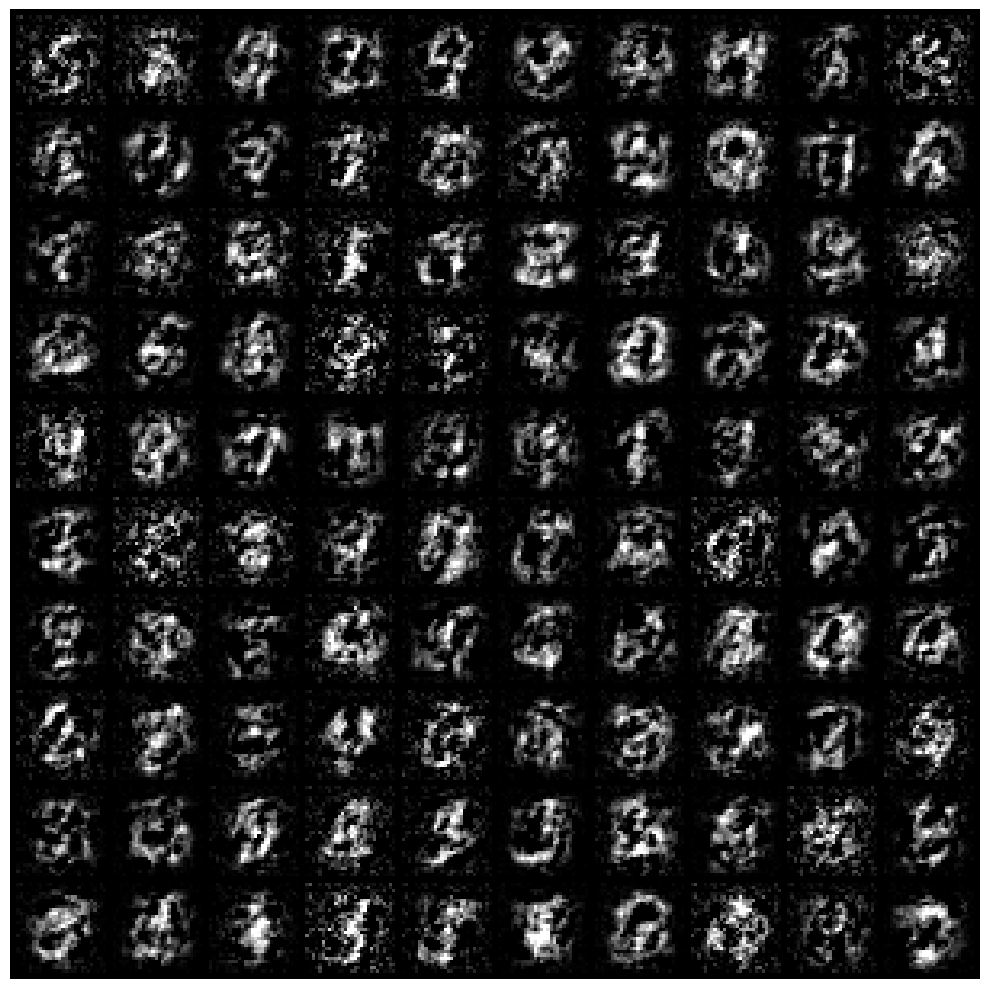

In [21]:
samples_denorm = samples * Xtrain.std() + Xtrain.mean()
mtg = make_grid(samples_denorm[:,:,-1].reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
centroids = score_model_gmm.mus.detach().reshape(-1, 1, 28, 28)
mtg = make_grid(centroids, nrow=5)
plt.imshow(mtg.permute(1, 2, 0) )
plt.show()


### 50 full rank GMM

In [27]:
ndim = Xtrain.shape[1]
gmm_components = 50
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
score_model_gmm.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
perturb = torch.randn(gmm_components, ndim)
perturb = perturb / torch.norm(perturb, dim=-1, keepdim=True)
score_model_gmm.mus.data = Xmean[None, :].repeat(gmm_components, 1) + perturb * 10

In [28]:

epochs = 5000
score_model_gmm, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm,
        sigma=sigma_max, lr=0.0005, nepochs=epochs, batch_size=batch_size, device="cuda") # clipnorm=1,
# 50 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 268.291
# step 1999 loss 114.897: 100%|██████████| 2000/2000 [37:20<00:00,  1.12s/it]

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 300.556


number of parameters 30811250
Final step 5000 loss 112.121


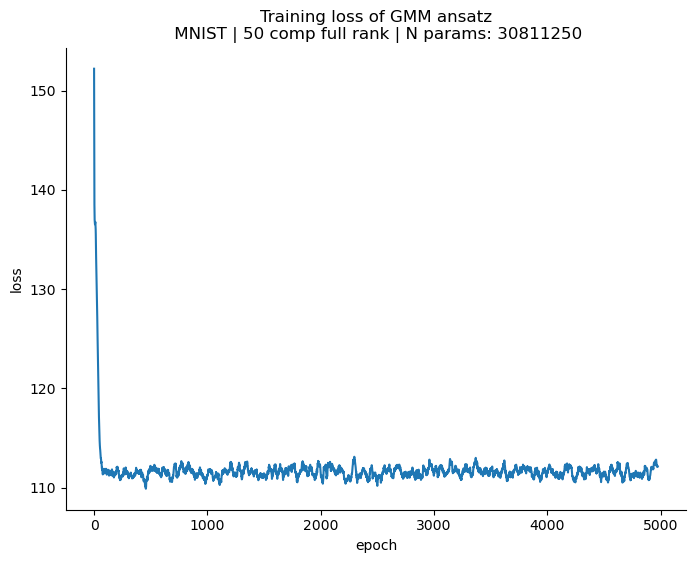

In [29]:
num_params = sum(p.numel() for p in score_model_gmm.parameters() if p.requires_grad)
print("number of parameters", num_params)
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid)/ker_wid, mode='valid')
print (f"Final step {len(loss_traj)} loss {smooth_loss_traj[-1]:.3f}")

plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of GMM ansatz\n MNIST | {gmm_components} comp full rank | N params: {num_params}")
plt.show()

In [30]:
samples = reverse_diffusion_time_dep_torch(score_model_gmm, 
        sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, 
        exact=False, device="cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


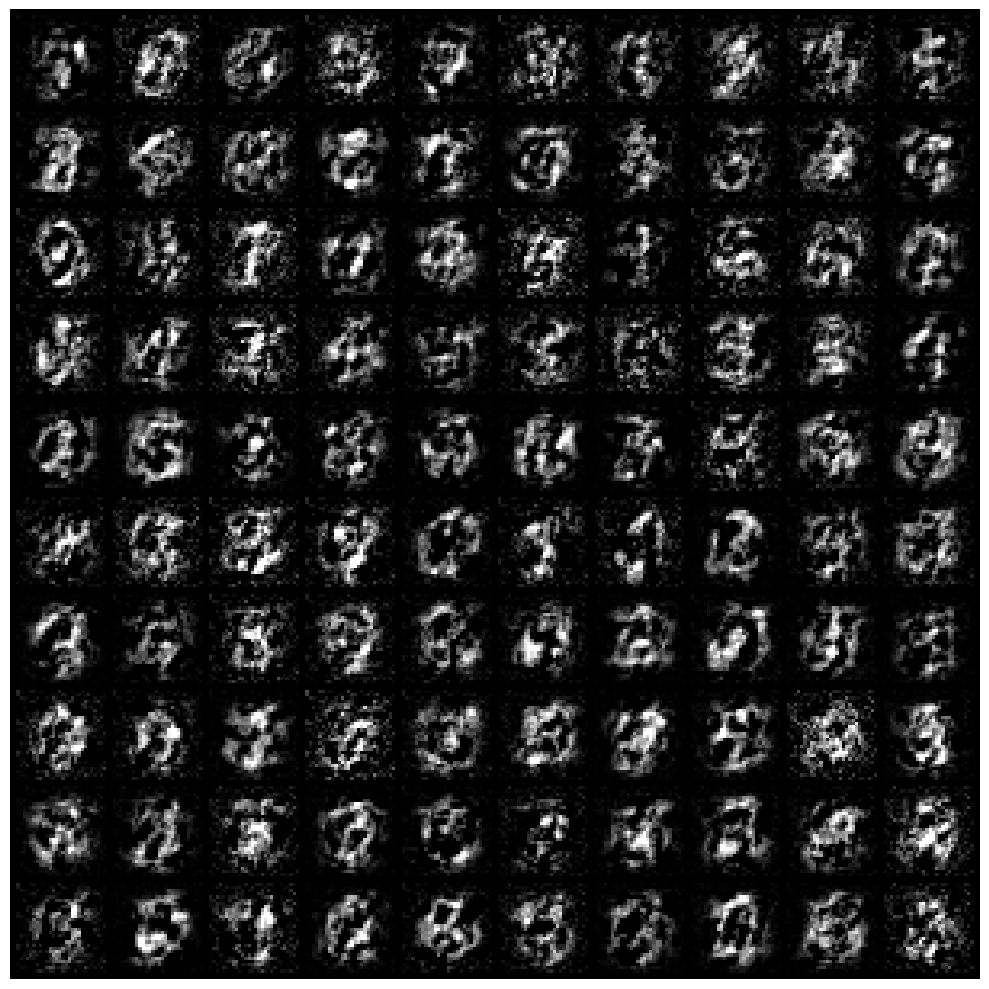

In [31]:
samples_denorm = samples * Xtrain.std() + Xtrain.mean()
mtg = make_grid(samples_denorm[:,:,-1].reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


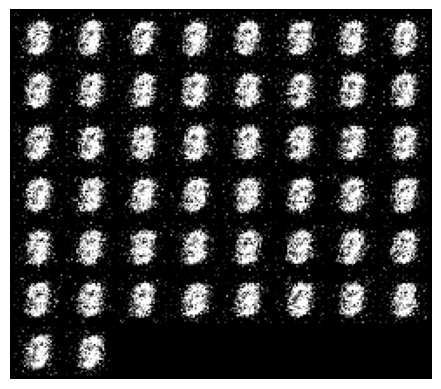

In [34]:
centroids = score_model_gmm.mus.detach().cpu().reshape(-1, 1, 28, 28)
mtg = make_grid(centroids, nrow=8)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

### 100 non full rank GMM

In [43]:
ndim = Xtrain.shape[1]
nrank = 200
gmm_components = 100
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_lowrk = GMM_ansatz_net_lowrank(ndim=ndim,
           n_components=gmm_components, n_rank=nrank, sigma=sigma_max)
# Data PC initialization
score_model_lowrk.logLambdas.data = logLamda_init[None, :nrank].repeat(gmm_components, 1)
score_model_lowrk.Us.data = U_init[None, :, :nrank].repeat(gmm_components, 1, 1)
perturb = torch.randn(gmm_components, ndim)
perturb = perturb / torch.norm(perturb, dim=-1, keepdim=True)
score_model_lowrk.mus.data = Xmean[None, :] + perturb * 5

In [44]:
epochs = 5000
score_model_lowrk, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_lowrk,
        sigma=sigma_max, lr=0.0002, nepochs=epochs, batch_size=batch_size, device="cuda") # clipnorm=1,
# step 0 loss 375.200
# step 1999 loss 118.352: 100%|██████████| 2000/2000 [10:10<00:00,  3.27it/s]
# 10 mins, loss around 120,
# 5510700 parameters 5M

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 265.237


number of parameters 15778500
Final step 5000 loss 297.999


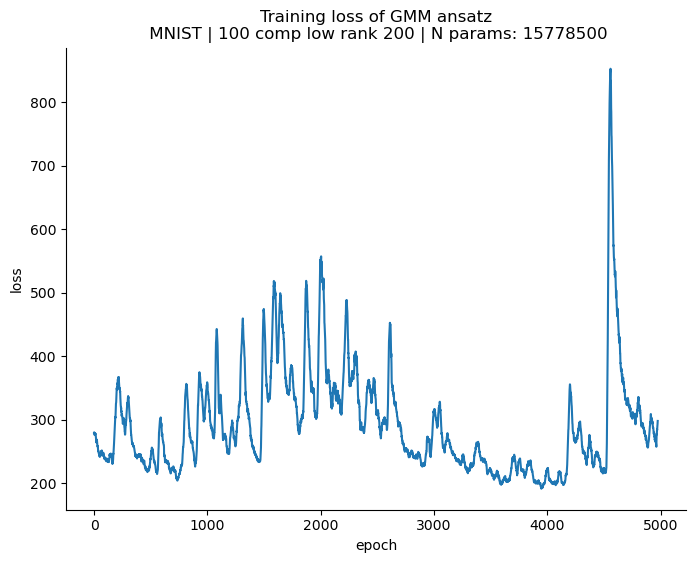

In [45]:
num_params = sum(p.numel() for p in score_model_lowrk.parameters() if p.requires_grad)
print("number of parameters", num_params)
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid)/ker_wid, mode='valid')
print (f"Final step {len(loss_traj)} loss {smooth_loss_traj[-1]:.3f}")

plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of GMM ansatz\n MNIST | {gmm_components} comp low rank {nrank} | N params: {num_params}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


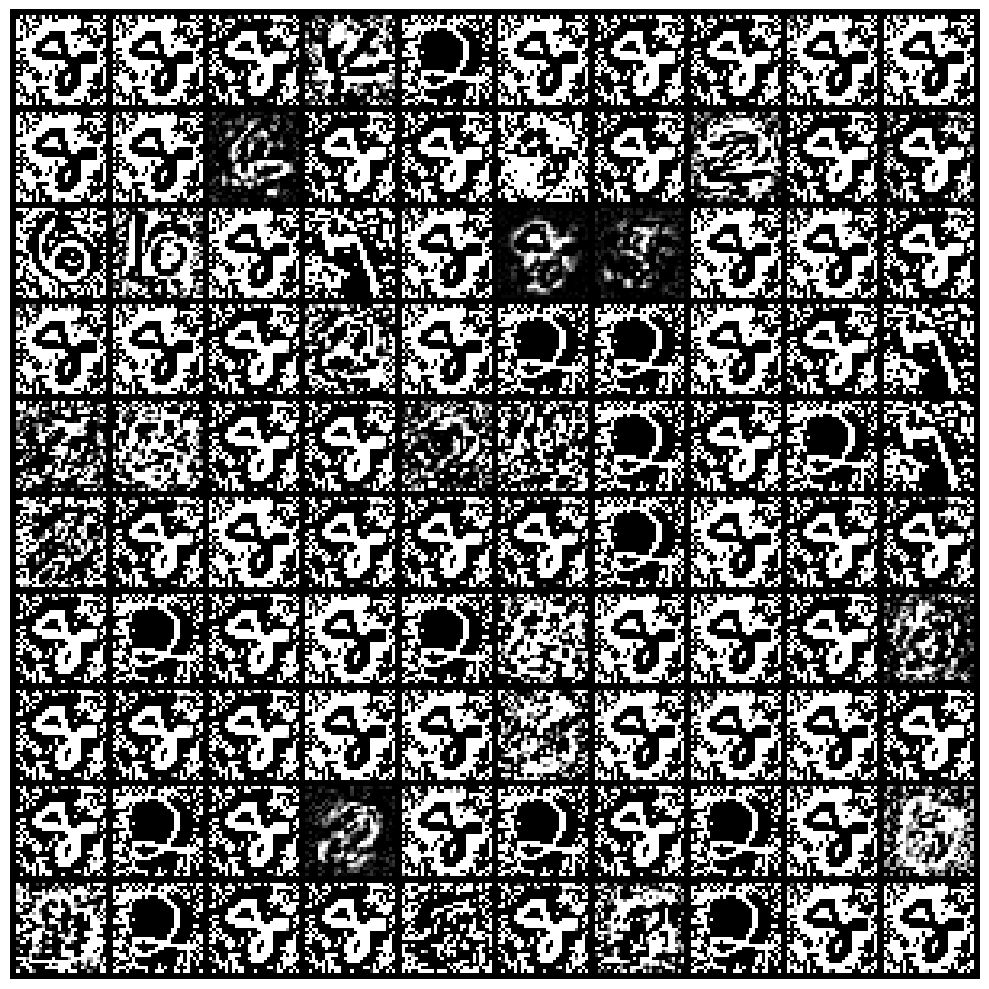

In [46]:
samples = reverse_diffusion_time_dep_torch(score_model_lowrk, 
        sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, 
        exact=False, device="cuda")
samples_denorm = samples * Xtrain.std() + Xtrain.mean()
mtg = make_grid(samples_denorm[:,:,-1].reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


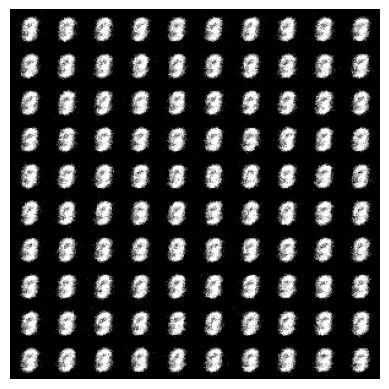

In [47]:
centroids = score_model_lowrk.mus.detach().cpu().reshape(-1, 1, 28, 28)
mtg = make_grid(centroids, nrow=10)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

### KMeans initializations

In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans
# kmeans = KMeans(n_clusters=50, random_state=0).fit(Xtrain_norm)
kmeans = MiniBatchKMeans(n_clusters=50, random_state=0, batch_size=2048, verbose=1).fit(Xtrain_norm)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 3131484.747459087
Init 2/3 with method k-means++
Inertia for init 2/3: 3151060.893490196
Init 3/3 with method k-means++
Inertia for init 3/3: 3218909.1866551344
Minibatch step 1/2929: mean batch inertia: 504.90554638370367
Minibatch step 2/2929: mean batch inertia: 348.0095235243042, ewa inertia: 348.0095235243042
Minibatch step 3/2929: mean batch inertia: 338.5212960954484, ewa inertia: 347.36180466047534
Minibatch step 4/2929: mean batch inertia: 337.1054708362559, ewa inertia: 346.6616506073095
Minibatch step 5/2929: mean batch inertia: 331.9809149992216, ewa inertia: 345.6594624262671
Minibatch step 6/2929: mean batch inertia: 334.13124232955556, ewa inertia: 344.87248238399894
Minibatch step 7/2929: mean batch inertia: 329.6379605159852, ewa inertia: 343.8324896910208
Minibatch step 8/2929: mean batch inertia: 330.6879780063477, ewa inertia: 342.9351726486312
Minibatch step 9/2929: mean batch inertia: 332.7818541079047, ewa iner

In [22]:
kmeans.cluster_centers_.shape

(50, 784)

In [63]:
# estimate covariance matrix of each cluster
covmats = []
eigval_col = []
eigvec_col = []
for i in range(50):
    print(i, "number of samples", np.sum(kmeans.labels_ == i))
    covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
    # PCA to reduce dimension
    eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64))
    eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
    eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
    eigval_col.append(eigval)
    eigvec_col.append(eigvec)
    covmats.append(covmat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


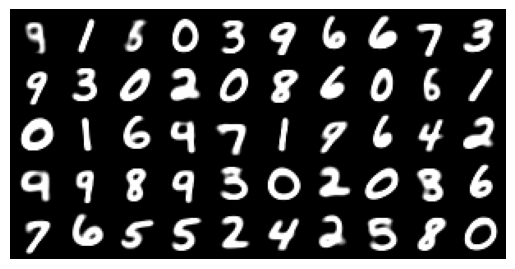

In [ ]:
# visualize the cluster centers
centroids = kmeans.cluster_centers_.reshape(-1, 1, 28, 28)
mtg = make_grid(torch.from_numpy(centroids), nrow=10)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 151.5, 151.5, -0.5)

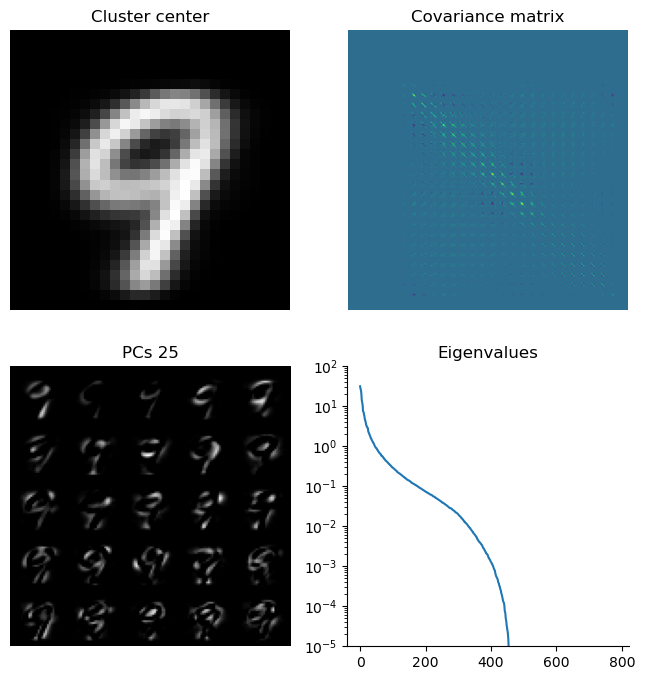

In [100]:
# visualize the covariance matrix & PC
cid = 5
nPC = 25
fig, axs = plt.subplots(2, 2, figsize=[8, 8])
axs[0,0].imshow(kmeans.cluster_centers_[cid].reshape(28, 28), cmap="gray")
axs[0,0].set_title("Cluster center")
axs[0,0].axis("off")
axs[0,1].imshow(covmats[cid])
axs[0,1].set_title("Covariance matrix")
axs[0,1].axis("off")
axs[1,1].semilogy(eigval_col[cid])
axs[1,1].set_ylim(1E-5, 1E2)
axs[1,1].set_title("Eigenvalues")
nrow = int(np.sqrt(nPC))
mtg = make_grid(eigvec_col[cid].reshape(1, 28, 28, -1).permute(3,0,1,2)[:nPC], nrow=nrow)
axs[1,0].imshow(mtg.permute(1, 2, 0) / mtg.max())
# axs[3].imshow(eigvec_col[cid].reshape(28, 28, -1)[:, :, 0], cmap="gray")
axs[1,0].set_title(f"PCs {nPC}")
axs[1,0].axis("off")

In [ ]:
innerprod = eigvec_col[0] @ eigvec_col[2].T
plt.imshow(innerprod.detach().cpu())
plt.colorbar()
plt.show()

In [60]:
ndim = Xtrain.shape[1]
gmm_components = 50
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm_kmean = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
score_model_gmm_kmean.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm_kmean.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
score_model_gmm_kmean.mus.data = torch.from_numpy(kmeans.cluster_centers_).float()

In [62]:
epochs = 1000
optimizer = torch.optim.Adam([
                            {'params': score_model_gmm_kmean.Us, 'lr': 0.0005},
                            {'params': score_model_gmm_kmean.mus, 'lr': 0.001},
                            {'params': score_model_gmm_kmean.logLambdas, 'lr': 0.002},
                        #     {'params': score_model_gmm_kmean.logweights, 'lr': 0.01}
                        ],
                             lr=0.01)
score_model_gmm_kmean, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_kmean,
        optimizer=optimizer, nepochs=epochs, batch_size=batch_size, 
        sigma=sigma_max, device="cuda") # clipnorm=1,
# 50 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 268.291
# step 1999 loss 114.897: 100%|██████████| 2000/2000 [37:20<00:00,  1.12s/it]

Using provided optimizer, overriding lr


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 199.920


In [27]:
epochs = 2000
score_model_gmm_kmean, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_kmean,
        sigma=sigma_max, lr=0.0001, nepochs=epochs, batch_size=batch_size, device="cuda") # clipnorm=1,
# 50 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 268.291
# step 1999 loss 114.897: 100%|██████████| 2000/2000 [37:20<00:00,  1.12s/it]

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 107.068


Optimizer hacking
* SGD is not helping
* 

In [51]:
epochs = 1000
optimizer = torch.optim.SGD(score_model_gmm_kmean.parameters(), lr=0.01)
score_model_gmm_kmean, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_kmean,
        optimizer=optimizer, nepochs=epochs, batch_size=batch_size, 
        sigma=sigma_max, device="cuda") # clipnorm=1,
# 50 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 268.291
# step 1999 loss 114.897: 100%|██████████| 2000/2000 [37:20<00:00,  1.12s/it]

Using provided optimizer, overriding lr


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 108.941


KeyboardInterrupt: 

In [47]:
epochs = 2000
score_model_gmm_kmean, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_kmean,
        sigma=sigma_max, lr=0.05, nepochs=epochs, batch_size=batch_size, device="cuda", clipnorm=1) # clipnorm=1,
# 50 full Gaussian GMM 0.0005 lr, 2000 epochså
# step 0 loss 268.291
# step 1999 loss 114.897: 100%|██████████| 2000/2000 [37:20<00:00,  1.12s/it]

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 407250.875


In [30]:
score_model_gmm_kmean.Us.shape

torch.Size([50, 784, 784])

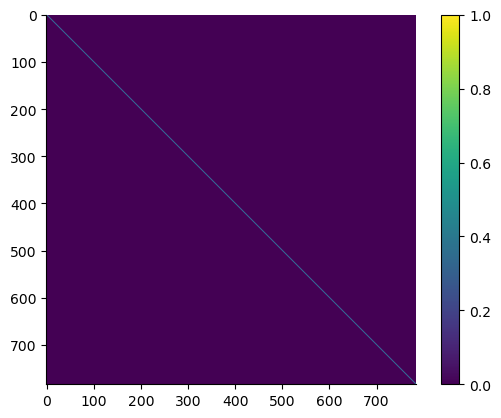

In [54]:
innerprod = score_model_gmm_kmean.Us[0] @ score_model_gmm_kmean.Us[0].T
plt.imshow(innerprod.detach().cpu())
plt.colorbar()
plt.show()


In [44]:
print("U weight norm",score_model_gmm_kmean.Us[0].norm().item())
print("U grad norm", score_model_gmm_kmean.Us.grad[0].norm().item())
print("U grad / weight ratio", score_model_gmm_kmean.Us.grad[0].norm().item() / score_model_gmm_kmean.Us[0].norm().item())
print("Lambda weight norm",score_model_gmm_kmean.logLambdas.norm().item())
print("Lambda grad norm", score_model_gmm_kmean.logLambdas.grad.norm().item())
print ("Lambda grad / weight ratio", score_model_gmm_kmean.logLambdas.grad.norm().item() / score_model_gmm_kmean.logLambdas.norm().item())
print("mu weight norm",score_model_gmm_kmean.mus.norm().item())
print("mu grad norm", score_model_gmm_kmean.mus.grad.norm().item())
print("mu grad / weight ratio", score_model_gmm_kmean.mus.grad.norm().item() / score_model_gmm_kmean.mus.norm().item())
print("pi weight norm",score_model_gmm_kmean.logweights.norm().item())
print("pi grad norm", score_model_gmm_kmean.logweights.grad.norm().item())
print("pi grad / weight ratio", score_model_gmm_kmean.logweights.grad.norm().item() / score_model_gmm_kmean.logweights.norm().item())

U weight norm 29.555498123168945
U grad norm 6.807952672716056e-07
U grad / weight ratio 2.303447109686577e-08
Lambda weight norm 1131.917236328125
Lambda grad norm 0.13710720837116241
Lambda grad / weight ratio 0.00012112829805112818
mu weight norm 155.2152557373047
mu grad norm 1.1955679655075073
mu grad / weight ratio 0.0077026446906156955
pi weight norm 27.922592163085938
pi grad norm 9.486411727266386e-05
pi grad / weight ratio 3.397396513855027e-06


### GMM initialize with correct Kmeans center + covariance

Note that GMM is not a very bad model of images, good parameters of GMM exist (i.e. parameters estimated by Kmeans / EM). 

* 50 full Gaussian GMM with Kmeans mean + cov initialization => 72 loss
* 100 full Gaussian GMM with Kmeans mean + cov initialization => 64 loss
* 200 full Gaussian GMM with Kmeans mean + cov initialization => 56.22 loss 

In [108]:
from sklearn.cluster import KMeans, MiniBatchKMeans
# kmeans = KMeans(n_clusters=50, random_state=0).fit(Xtrain_norm)
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0, batch_size=2048, verbose=1).fit(Xtrain_norm)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 2813040.8667306923
Init 2/3 with method k-means++
Inertia for init 2/3: 2813712.3577361796
Init 3/3 with method k-means++
Inertia for init 3/3: 2788756.1150021544
Minibatch step 1/2929: mean batch inertia: 459.7645289666375
Minibatch step 2/2929: mean batch inertia: 320.2766292197611, ewa inertia: 320.2766292197611
Minibatch step 3/2929: mean batch inertia: 312.3704697593438, ewa inertia: 319.7369110625659
Minibatch step 4/2929: mean batch inertia: 306.3488045746614, ewa inertia: 318.8229648920945
Minibatch step 5/2929: mean batch inertia: 306.39338884997636, ewa inertia: 317.9744533094789
Minibatch step 6/2929: mean batch inertia: 300.9985250171531, ewa inertia: 316.81558258590155
Minibatch step 7/2929: mean batch inertia: 302.02446171700257, ewa inertia: 315.8058588966462
Minibatch step 8/2929: mean batch inertia: 304.3405165998743, ewa inertia: 315.0231712406475
Minibatch step 9/2929: mean batch inertia: 299.555517826682, ewa iner

In [111]:
kmeans.n_clusters

100

In [112]:
covmats = []
eigval_col = []
eigvec_col = []
freq_col = []
for i in trange(kmeans.n_clusters):
    n_samples = np.sum(kmeans.labels_ == i)
    # print(i, "number of samples", n_samples)
    freq_col.append(n_samples)
    covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
    # PCA to reduce dimension
    eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64).cuda())
    eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
    eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
    eigval_col.append(eigval)
    eigvec_col.append(eigvec)
    covmats.append(covmat)
eigval_mat = torch.stack(eigval_col, dim=0)
eigvec_mat = torch.stack(eigvec_col, dim=0)
freq_vec = torch.tensor(freq_col)

  0%|          | 0/100 [00:00<?, ?it/s]

In [113]:
ndim = Xtrain.shape[1]
gmm_components = 100
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm_km_cov = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
# score_model_gmm_km_cov.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm_km_cov.logLambdas.data = torch.log(eigval_mat + 1E-5).float()
# score_model_gmm_km_cov.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
score_model_gmm_km_cov.Us.data = eigvec_mat.float()
score_model_gmm_km_cov.mus.data = torch.from_numpy(kmeans.cluster_centers_).float()
score_model_gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())

In [114]:
epochs = 100
optimizer = torch.optim.Adam([
                            {'params': score_model_gmm_km_cov.Us, 'lr': 0.0000},
                            {'params': score_model_gmm_km_cov.mus, 'lr': 0.000},
                            {'params': score_model_gmm_km_cov.logLambdas, 'lr': 0.000},
                        #     {'params': score_model_gmm_kmean.logweights, 'lr': 0.01}
                        ],
                             lr=0.01)
score_model_gmm_km_cov, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_km_cov,
        optimizer=optimizer, nepochs=epochs, batch_size=batch_size, 
        sigma=sigma_max, device="cuda")
print("Average loss", np.mean(loss_traj))

Using provided optimizer, overriding lr


  0%|          | 0/100 [00:00<?, ?it/s]

step 0 loss 64.547


In [107]:
epochs = 100
optimizer = torch.optim.Adam([
                            {'params': score_model_gmm_km_cov.Us, 'lr': 0.0000},
                            {'params': score_model_gmm_km_cov.mus, 'lr': 0.000},
                            {'params': score_model_gmm_km_cov.logLambdas, 'lr': 0.000},
                        #     {'params': score_model_gmm_kmean.logweights, 'lr': 0.01}
                        ],
                             lr=0.01)
score_model_gmm_km_cov, loss_traj = train_score_td(Xtrain_norm, score_model_td=score_model_gmm_km_cov,
        optimizer=optimizer, nepochs=epochs, batch_size=batch_size, 
        sigma=sigma_max, device="cuda") # clipnorm=1,
# 50 full Gaussian GMM with Kmeans mean + cov initialization => 72 loss

Using provided optimizer, overriding lr


  0%|          | 0/100 [00:00<?, ?it/s]

step 0 loss 72.258


In [125]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def eval_score_model(Xtrain_norm, score_model, Nbatch=100, batch_size=2048, sigma_max=10, device="cuda"):
    score_model, loss_traj = train_score_td(Xtrain_norm, 
            score_model_td=score_model,
            lr=0.0000, nepochs=Nbatch, batch_size=batch_size, 
            sigma=sigma_max, device="cuda") # clipnorm=1,
    # 50 full Gaussian GMM with Kmeans mean + cov initialization => 72 loss
    Nparameters = count_parameters(score_model)
    print (f"Average loss", np.mean(loss_traj), f" ({batch_size}x{Nbatch} pnts)")
    print("Num of parameters", count_parameters(score_model))
    return np.mean(loss_traj), Nparameters
    

In [135]:
from sklearn.cluster import KMeans, MiniBatchKMeans
def kmeans_initialized_gmm(Xtrain, n_clusters, 
                           n_rank=None,
                           kmeans_batch=2048, 
                           kmeans_random_seed=0,
                           kmeans_verbose=0,
                           gmm_random_seed=42, 
                           lambda_EPS=1E-5, 
                           sigma_max=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
            random_state=kmeans_random_seed, batch_size=kmeans_batch, verbose=kmeans_verbose)
    kmeans.fit(Xtrain_norm)
    print("Kmeans fitting completing, loss ", kmeans.inertia_)
    covmats = []
    eigval_col = []
    eigvec_col = []
    freq_col = []
    for i in trange(kmeans.n_clusters):
        n_samples = np.sum(kmeans.labels_ == i)
        # print(i, "number of samples", n_samples)
        freq_col.append(n_samples)
        covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
        # PCA to reduce dimension
        covmat = covmat + lambda_EPS * torch.eye(covmat.shape[0])
        eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64).cuda())
        eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
        eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
        eigval_col.append(eigval)
        eigvec_col.append(eigvec)
        covmats.append(covmat)
    eigval_mat = torch.stack(eigval_col, dim=0)
    eigvec_mat = torch.stack(eigvec_col, dim=0)
    freq_vec = torch.tensor(freq_col)
    center_mat = torch.from_numpy(kmeans.cluster_centers_)
    print("cov PCA completed for each cluster.")
    ndim = Xtrain.shape[1]
    torch.manual_seed(gmm_random_seed)
    if n_rank is None:
        gmm_km_cov = GMM_ansatz_net(ndim=ndim,
                    n_components=n_clusters, sigma=sigma_max)
        # Data PC initialization
        gmm_km_cov.logLambdas.data = torch.log(eigval_mat + lambda_EPS).float() #
        gmm_km_cov.Us.data = eigvec_mat.float()
        gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())
        gmm_km_cov.mus.data = center_mat.float()
        print("GMM ansatz model initialized.")
    else:
        print("Low rank GMM ansatz")
        assert type(n_rank) == int and n_rank > 0 and n_rank < ndim
        gmm_km_cov = GMM_ansatz_net_lowrank(ndim=ndim,
                    n_components=n_clusters, n_rank=n_rank, sigma=sigma_max)
        
        gmm_km_cov.logLambdas.data = torch.log(eigval_mat + lambda_EPS).float()[:, :n_rank]
        gmm_km_cov.Us.data = eigvec_mat.float()[:, :, :n_rank]
        gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())
        gmm_km_cov.mus.data = center_mat.float()
        print("GMM low rank ansatz model initialized.")
    return gmm_km_cov, kmeans


In [142]:
n_clusters = 50
n_rank = None
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  19701055.39941834


  0%|          | 0/50 [00:00<?, ?it/s]

cov PCA completed for each cluster.
GMM ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 72.258
Average loss 72.26619277954102  (2048x50 pnts)
Num of parameters 30811250
Average loss 72.266 | N params 30811250


In [139]:
n_clusters = 50
n_rank = 400
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  19701055.39941834


  0%|          | 0/50 [00:00<?, ?it/s]

cov PCA completed for each cluster.
Low rank GMM ansatz
GMM low rank ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 70.840
Average loss 72.34965042114258  (2048x50 pnts)
Num of parameters 15739250
Average loss 72.350 | N params 15739250


In [141]:
n_clusters = 50
n_rank = 250
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  19701055.39941834


  0%|          | 0/50 [00:00<?, ?it/s]

cov PCA completed for each cluster.
Low rank GMM ansatz
GMM low rank ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 77.693
Average loss 79.92631393432617  (2048x50 pnts)
Num of parameters 9851750
Average loss 79.926 | N params 9851750


In [ ]:
n_clusters = 100
n_rank = None
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  15861150.72746038


  0%|          | 0/250 [00:00<?, ?it/s]

cov PCA completed for each cluster.
GMM ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 51.795
Average loss 52.49658203125  (2048x50 pnts)
Num of parameters 154056250
Average loss 52.497 | N params 154056250


In [143]:
n_clusters = 250
n_rank = None
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  15861150.72746038


  0%|          | 0/250 [00:00<?, ?it/s]

cov PCA completed for each cluster.
GMM ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 51.795
Average loss 52.49658203125  (2048x50 pnts)
Num of parameters 154056250
Average loss 52.497 | N params 154056250


In [144]:
n_clusters = 250
n_rank = 250
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  15861150.72746038


  0%|          | 0/250 [00:00<?, ?it/s]

cov PCA completed for each cluster.
Low rank GMM ansatz
GMM low rank ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 52.401
Average loss 52.64290237426758  (2048x50 pnts)
Num of parameters 49258750
Average loss 52.643 | N params 49258750


In [145]:
n_clusters = 250
n_rank = 150
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print("N components", n_clusters, "N rank", n_rank if n_rank is not None else "None")
print(f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  15861150.72746038


  0%|          | 0/250 [00:00<?, ?it/s]

cov PCA completed for each cluster.
Low rank GMM ansatz
GMM low rank ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 58.058
Average loss 59.51494682312012  (2048x50 pnts)
Num of parameters 29633750
Average loss 59.515 | N params 29633750


In [146]:
n_clusters = 250
n_rank = 64
score_model_gmm_km_cov, kmeans = kmeans_initialized_gmm(Xtrain_norm, n_clusters, n_rank=n_rank, kmeans_verbose=0)
eval_loss, Nparams = eval_score_model(Xtrain_norm, score_model_gmm_km_cov, Nbatch=50)
print (f"Average loss {eval_loss:.3f} | N params {Nparams}")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  15861150.72746038


  0%|          | 0/250 [00:00<?, ?it/s]

cov PCA completed for each cluster.
Low rank GMM ansatz
GMM low rank ansatz model initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

step 0 loss 138.813
Average loss 134.78977005004882  (2048x50 pnts)
Num of parameters 12756250
Average loss 134.790 | N params 12756250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


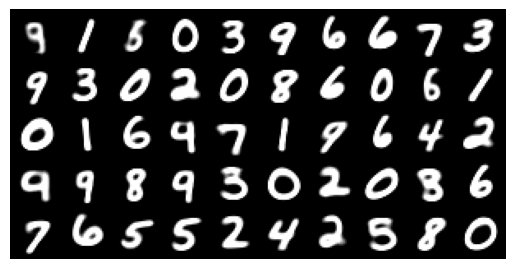

In [29]:
# plot the centers
centroids = score_model_gmm_kmean.mus.cpu().detach().reshape(-1, 1, 28, 28)
mtg = make_grid(centroids, nrow=10)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

## MLP Baseline 

In [ ]:
epochs = 2000
batch_size = 2048
score_model_edm = ScoreModel_Time_edm(sigma=sigma_max, ndim=ndim,
                nlayers=8, nhidden=512, time_embed_dim=64,
                act_fun=nn.Tanh)
print("number of parameters", sum(p.numel() for p in score_model_edm.parameters() if p.requires_grad))
score_model_edm = train_score_td(Xtrain_norm, score_model_td=score_model_edm,
        sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size)
# loss around 200, could be slower
# 1 mins for 2000 epochs

In [ ]:
score_model_gauss(Xtrain_norm[:1], torch.tensor([.2])).norm()

In [ ]:
score_model_edm(Xtrain_norm[:1], torch.tensor([.2])).norm()



In [ ]:
from torchvision.utils import make_grid
centroids = score_model_lowrk.mus.detach().reshape(-1, 1, 28, 28)
mtg = make_grid(centroids)
plt.imshow(mtg.permute(1, 2, 0) / mtg.max())
plt.show()


In [ ]:
Us = score_model_td.Us.detach()
Lambdas = score_model_td.logLambdas.exp().detach()
compon = 0
PCsort = Lambdas[compon, :].argsort(descending=True)
Us_sorted = Us[compon, :, PCsort,]


In [ ]:
mtg = make_grid(Us_sorted[:, :100].reshape(1, 28, 28, -1).permute(3, 0, 1, 2), nrow=10)
plt.imshow(mtg.permute(1, 2, 0) / mtg.max())
plt.show()


In [ ]:
plt.imshow(Us_sorted[:, 5].reshape(28, 28))
plt.show()

In [ ]:
# obsolete
from sklearn.mixture import GaussianMixture
gmm_sk = GaussianMixture(n_components=gmm_components, covariance_type="full",
                         verbose=1, tol=1e-3, max_iter=1000)
gmm_sk.fit(Xtrain)
# will take forever to converge

In [ ]:
from sklearn.model_selection import train_test_split
figdir = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/HaimDiffusionRNNProj/Ring_GMM_ansatz_train"
import os
os.makedirs(figdir, exist_ok=True)
# ring_X = generate_ring_samples_torch(50)
ring_X = generate_spiral_samples_torch(20, a=0.4, b=0.15)
# train test split
Xtrain, Xtest = ring_X, torch.empty(0, 2)  # train_test_split(ring_X, test_size=0.0001, random_state=42)
# Xtrain, Xtest = train_test_split(ring_X, test_size=0.0001, random_state=42)
sigma_max = 10
gmm_components = 150
# mlp_width = 8
# mlp_depth = 3 # note, 2 layer usually doesn't work. 3 layer works.
# act_fun = nn.Tanh
# cfg_str = f"mlp {mlp_depth} layer width{mlp_width} {act_fun.__name__} sigma{sigma_max}"
cfg_str = f"sigma{sigma_max} dense"
cfg_str = f"sigma{sigma_max} dense spiral, {gmm_components} components"
for batch_size in [1024]: # 128, 256, 512,
    for epochs in [250, 500, 750, 1000, 1500, 2000,]:# :
        torch.manual_seed(42)
        score_model_td = GMM_ansatz_net(ndim=2, n_components=gmm_components)
        score_model_td = train_score_td(Xtrain, score_model_td=score_model_td,
                        sigma=sigma_max, lr=0.05, nepochs=epochs, batch_size=batch_size)
        
        x_traj_denoise = reverse_diffusion_time_dep(score_model_td, sampN=3000, sigma=sigma_max, nsteps=1000, ndim=2, exact=False)
        figh = visualize_diffusion_distr(x_traj_denoise,
                             explabel=f"Time Dependent NN trained from weighted denoising\nepoch{epochs} batch {batch_size}\n{cfg_str}")
        figh.axes[1].set_xlim([-2.5, 2.5])
        figh.axes[1].set_ylim([-2.5, 2.5])
        saveallforms(figdir, f"ring_NN_contour_train_Ncomp{gmm_components}_batch{batch_size}_ep{epochs:04d}_sde")
        figh.show()
        plt.figure(figsize=(7, 7))
        plt.scatter(x_traj_denoise[:, 0, -1], x_traj_denoise[:, 1, -1], alpha=0.1, lw=0.1, color="k", label="score net gen samples")
        plt.scatter(Xtrain[:, 0], Xtrain[:, 1], s=200, alpha=0.9, label="train", marker="o")
        plt.scatter(Xtest[:, 0], Xtest[:, 1], s=200, alpha=0.9, label="test", marker="o")
        plt.axis("image")
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.title(f"NN Generated Samples\nepoch{epochs} batch {batch_size}\n{cfg_str}")
        plt.legend()
        plt.tight_layout()
        saveallforms(figdir, f"ring_NN_samples_train_Ncomp{gmm_components}_batch{batch_size}_ep{epochs:04d}_sde")
        plt.show()

In [ ]:
# len(list(score_model_td.parameters()))
# count the total number of parameters
sum(p.numel() for p in score_model_td.parameters() if p.requires_grad)





In [ ]:
# GMM ansatz
ndim = 2
n_components = 10
mus = torch.randn(n_components, ndim)
covs = torch.randn(n_components, ndim, ndim)
covs = covs @ covs.transpose(-1, -2)
weights = torch.ones(n_components) / n_components

In [ ]:
x = torch.randn(1000, ndim)

torch.softmax()








